In [87]:
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

import pymysql
pymysql.install_as_MySQLdb()

import datetime as dt
import pandas as pd
import seaborn as sns
#from sqlalchemy import desc

In [205]:
start_date = '2015-04-15'
end_date = '2015-05-01'

**Create engine**

In [130]:
engine = create_engine('sqlite:///../Base/hawaii.sqlite')

In [131]:
#check if everything works
engine.execute('select * from station').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999995, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

**Check tables and column names**

In [132]:
inspector = inspect(engine)

In [133]:
tables = {} # all tables and columns. maybe useless
for table in inspector.get_table_names():
    print(f'Table name is "{table}", it contains columns: ')
    columns = inspector.get_columns(table)
    names = []
    for c in columns:
        names.append(c['name'])
        print(c['name'], c['type'])
    print()
    tables[table] = names

Table name is "measurement", it contains columns: 
id INTEGER
station VARCHAR
date VARCHAR
prcp FLOAT
tobs INTEGER

Table name is "station", it contains columns: 
id INTEGER
station VARCHAR
name VARCHAR
latitude FLOAT
longitude FLOAT
elevation FLOAT



**Declare a Base using automap and reflect database**

In [134]:
Base = automap_base()
Base.prepare(engine, reflect=True)

**Assign classes to variable**

In [135]:
Measurement = Base.classes.measurement
Station = Base.classes.station

## Precipitation Analysis

**Start a session to make queries**

In [136]:
session = Session(engine)

**Get information for the last year**

In [137]:
#find the last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_year = last_date[0][0:4]
last_date_month = last_date[0][5:7]
last_date_day = last_date[0][8:10]
date = dt.datetime(int(last_date_year), int(last_date_month), int(last_date_day))
year_ago = date - dt.timedelta(days=365)

In [155]:
last_year_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

**Create DF and plot it**

In [156]:
df = pd.DataFrame(last_year_prcp, columns=['date', 'precipitation'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


Text(0,0.5,'Precipitation')

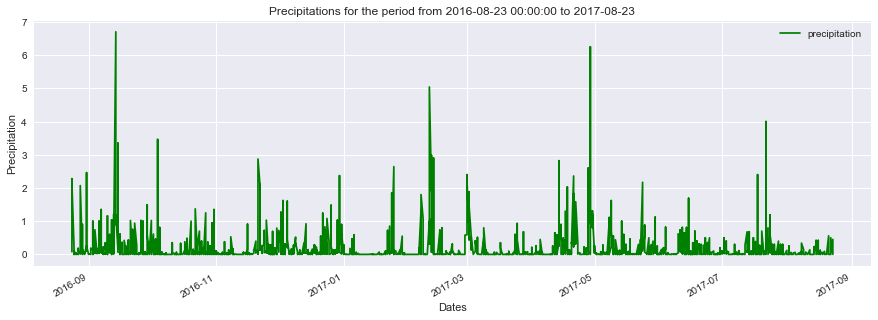

In [140]:
sns.set()
ax = df.plot(title=f'Precipitations for the period from {year_ago} to {last_date[0][0:10]}', color='green',\
             grid=True, figsize=(15,5))
ax.set_xlabel('Dates')
ax.set_ylabel('Precipitation')

**Get percipitation statistics**

In [141]:
df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [142]:
# Total # of stations
session.query(Measurement.station).distinct().count()

9

In [150]:
# List of stations activity
session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()

[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [162]:
# Most active station
most_active = session.query(Measurement.station).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).first()
most_active

('USC00519281')

In [168]:
last_year_temp = session.query(Measurement.tobs).filter(Measurement.date > year_ago).\
                    filter(Measurement.station == most_active[0]).all()

In [172]:
df = pd.DataFrame(last_year_temp, columns=['Temperature'])

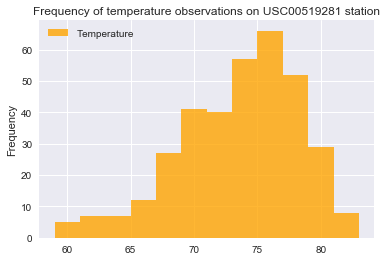

In [182]:
df.plot.hist(by='Temperature', bins=12, color='orange',\
             title=f'Frequency of temperature observations on {most_active[0]} station', alpha=0.8)

## Temperature Analysis

**

In [228]:
def calc_temps(start, end):
    min_temp = session.query(Measurement.tobs).filter(Measurement.date > start).filter(Measurement.date < end).\
    order_by(Measurement.tobs).first()
    max_temp = session.query(Measurement.tobs).filter(Measurement.date > start).filter(Measurement.date < end).\
    order_by(Measurement.tobs.desc()).first()
    average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.date > start).\
    filter(Measurement.date < end).all()
    return f'during the period from {start} to {end}:\
            minimum temperature was {min_temp[0]},\
            maximum temperature was {max_temp[0]},\
            average - {average_temp[0][0]}'

In [231]:
calc_temps(start_date, end_date)

'during the period from 2015-04-15 to 2015-05-01:            minimum temperature was 66,            maximum temperature was 83,            average - 73.65168539325843'